# Tarea Programada 3

**Profesora**: María Auxiliadora Mora

**Estudiante**: Marco Ferraro

## Introducción

En esta tarea se aplicarán conceptos básicos de aprendizaje automático utilizando redes neuronales convolucionales (CNN) y afinamiento de modelos de pre-entrenados para resolver problemas que involucran clasificación de imágenes. Las y los estudiantes deberán completar los ejercicio utilizando alguno de los conjuntos de datos propuestos al final del documento.

El objetivo del trabajo es poner en práctica las habilidades de investigación y el conocimiento adquirido durante el curso sobre aprendizaje profundo por medio de ejercicios prácticos que permitan a las y los estudiantes experimentar con algoritmos de aprendizaje
automático.

Para resolver el ejercicio se debe utilizar la biblioteca PyTorch, de no ser así, el ejercicio no
aportará al cálculo de la nota de la tarea.

## 1 Redes Convolusionales

Las redes convolucionales son una arquitectura de aprendizaje profundo para tareas de visión por computadora, que utilizan filtros para extraer características relevantes de imágenes.

Las CNNs son eficientes y generalizan bien en diferentes tareas visuales debido a su uso de parámetros compartidos y operaciones de agrupación. La transferencia de aprendizaje también mejora su rendimiento en nuevas tareas. Estas redes han revolucionado la visión por computadora y son fundamentales en inteligencia artificial.

### 1.1 Descripción del Problema y Objetivos

El problema presentado en esta tarea es de generar un clasificador de imagenes que logre clasificar, de manera efectiva, el conjunto de datos previamente proporcionado. 

Cada imagen representa uno de los siguientes sentimientos: 

* Felicidad
* Enojo
* Tristeza

El objetivo de este trabajo es generar un clasificador, por medio de un modelo de redes neuronales convolusionales, para poder obtener los rasgos de imagenes para poder clasificar de forma correcta nueva información.

### 1.2 Selección del Conjunto de Datos

Como se menciono anteriormente, se va a utilizar un dataset que contiene imagenes que expresan varias emociones. Estas imagenes van a variar ya que no hay un estandar o modelo a seguir para las imagenes, por lo tanto podemos ver dibujos animados o porta retratos. 

El conjunto esta formado por 265 imagenes.

https://www.kaggle.com/datasets/sanidhyak/human-face-emotions

### 1.3 Exploración de Datos

En esta seccion, se cargan los datos y se hará una pequeña exploración de las imagenes.

Adicionalmente se van a imprimir 5 imagenes aleatorias con su label respectivo.

In [2]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [36]:
LABELS = {
    0: "angry",
    1: "happy",
    2: "sad"
}

In [37]:


data_folder = './data'
emotions_folders = ["Angry", "Happy", "Sad"]

X = []
y = []
# Setting image to this size
image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])


for idx, emotion in enumerate(emotions_folders):
    emotion_folder = os.path.join(data_folder, emotion)
    for image_file in os.listdir(emotion_folder):
        image_path = os.path.join(emotion_folder, image_file)
        try:
            image = Image.open(image_path).convert("RGB")
            image_tensor = transform(image)
            X.append(image_tensor)
            y.append(idx)  
        except Exception as e:
            print(f"Error loading image: {image_path}. Error: {e}")

X = torch.stack(X)
y = torch.tensor(y)
X = X.to(device)
y = y.to(device)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: torch.Size([265, 3, 128, 128])
Shape of y: torch.Size([265])


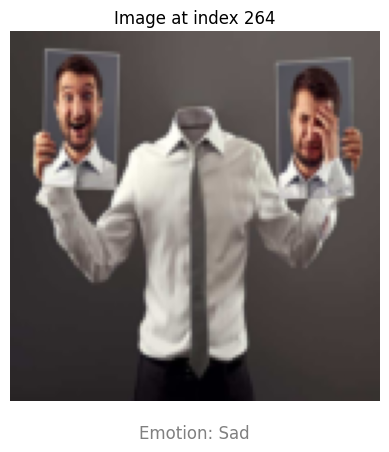

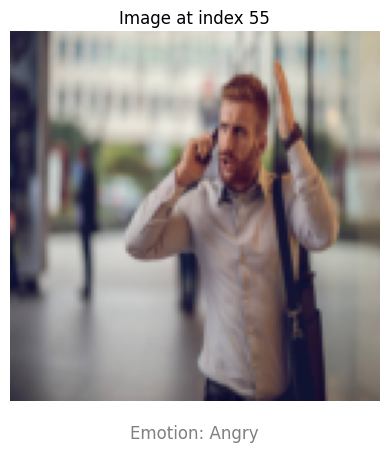

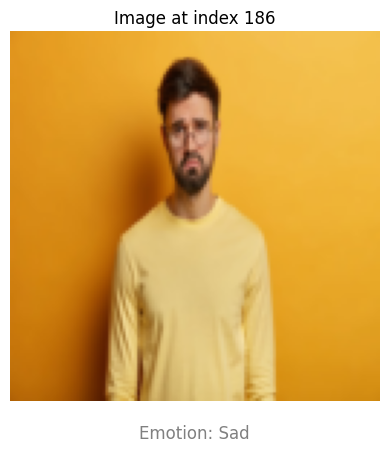

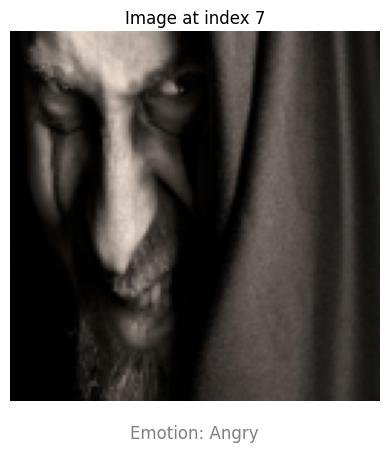

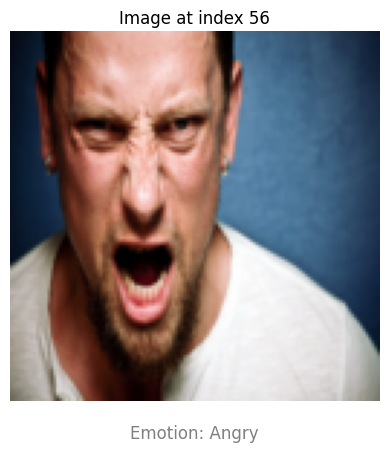

In [38]:


for i in range(5):
  random_idx = random.randint(0, X.shape[0] - 1)
  emotion_idx = y[random_idx].item()

  image_tensor = X[random_idx].cpu()

  image_np = image_tensor.permute(1, 2, 0).numpy()

  plt.imshow(image_np)
  plt.title(f"Image at index {random_idx}")
  plt.axis('off')
  plt.text(0.5, -0.1, f"Emotion: {emotions_folders[emotion_idx]}", transform=plt.gca().transAxes, ha='center', fontsize=12, color='gray')
  plt.show()


En esta parte vamos a analizar la cantidad de labels en el data set. No es un set tan grande pero podemos ver que el conjunto esta relativamente balanceado.

In [39]:
y_list = y.cpu().tolist()
label_counter = Counter(y_list)

for i in label_counter:
    print("Emotion:", LABELS.get(i), "| Count:", label_counter[i])

Emotion: angry | Count: 86
Emotion: happy | Count: 100
Emotion: sad | Count: 79


### 1.4 Datos de Entrenamiento y Validación

Utilizamos dos grupos de Data Loader para almacenar los datos de entrenamiento y los de validación

In [40]:
BATCH_SIZE = 32
NUM_EPOCHS = int(5e2)
LEARNING_RATE = 1e-3

dataset = torch.utils.data.TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# El loader de entrenamiento tiene Shuffle True para evitar overfitting. En cada entrenamiento de epocas
# los datos se van a estar reordenando
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


### 1.5 Definición de Red Convolusional

Adicionalmente, vamos a definir nuestra red neuronal convolusional. 
Unos aspectos importantes es que estamos usando Dropout dentro de las capas lineales para evitar un overfitting.

In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),  
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(128, 3),  # 3 classes: Angry, Happy, Sad
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

En este ciclo, se llevara a cabo el entrenamiendo del modelo 

In [42]:

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


print_epochs = [1, 10, 50, 100, 250, 500, 750]
loss_values = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    loss_values.append(train_loss)

    if (epoch + 1) in print_epochs:
        print(f"Epoch: [{epoch+1}/{NUM_EPOCHS}] | Loss: {train_loss:.4f}")


Epoch: [1/500] | Loss: 2.2185
Epoch: [10/500] | Loss: 0.6760
Epoch: [50/500] | Loss: 0.0799
Epoch: [100/500] | Loss: 0.0126
Epoch: [250/500] | Loss: 0.0014
Epoch: [500/500] | Loss: 0.0027


### 1.6 Curva de Error

Usando el ciclo de evaluación previo, podemos visualizar la curva de entrenamiento.

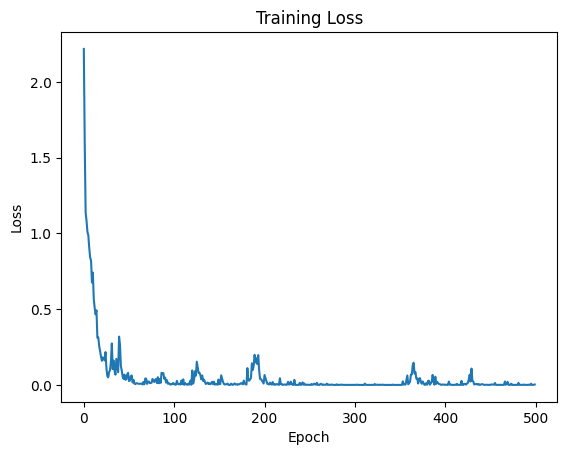

In [43]:
plt.plot(range(NUM_EPOCHS), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

A lo largo de 500 épocas, podemos ver como la función de perdida desciende rapidamente, acercandose al valor de 0. Sin embargo, a lo largo de la fase de entrenamiento vemos como hay "picos" que no obedecen a la tendencia general. Al final de la fase de entrenamiento la función de perdida genera un valor de 0.0027.

### 1.7 Matriz de confusión.

Adicionalmente, otra herramienta para analizar el rendimiento de modelos predictivos es la matriz de confusión. En esta sección vamos a generar una matriz de confusión a partir de las predicciones realizadas en el dataset de validación.

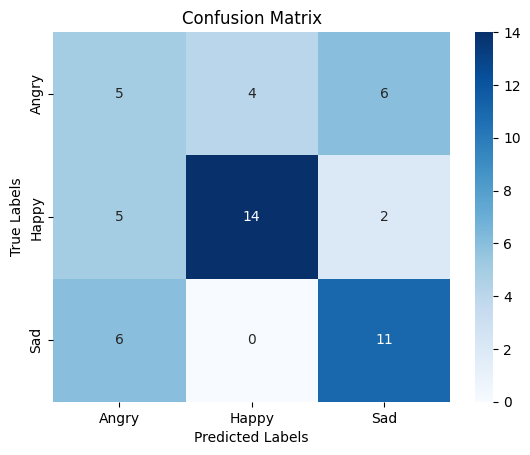

              precision    recall  f1-score   support

       Angry       0.31      0.33      0.32        15
       Happy       0.78      0.67      0.72        21
         Sad       0.58      0.65      0.61        17

    accuracy                           0.57        53
   macro avg       0.56      0.55      0.55        53
weighted avg       0.58      0.57      0.57        53



In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

conf_matrix = confusion_matrix(all_labels, all_predictions)

classes = ['Angry', 'Happy', 'Sad']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_predictions, target_names=classes))


Viendo los resultados, vemos que el modelo presenta un grado de precisión muy alto para clasificar imagenes felices, sin embargo no tiene un alto grado de precisión ni recall para el resto de imagenes.

Especialmente, para las imagenes de denotación "Angry" no logra tener un gran alto de accuracy, de hecho, para este tipo de imagenes el modelo clasifico 6 de 15 imagenes "Angry" como "Sad"

### 1.8 Mejoras realizadas

Este proyecto ha tenido varias iteraciones. No se ha podido aumentar el accuracy a niveles satisfactorios, pero volver la arquitectura más compleja al agregar normalización de Batches y dropout ha ayudado a mejorar el rendimiento del modelo.

### 1.8 Conclusiones

De los resultados se pueden llevar a cabo varias conclusiones con el trabajo realizado.

1. Tamaño del conjunto de datos: Una de las conclusiones es que tener un conjunto de datos más grande puede mejorar significativamente el rendimiento de la red convolucional. Un conjunto de datos más grande permite al modelo aprender patrones más representativos y generalizar mejor a nuevas imágenes. Si es posible, buscar formas de aumentar el tamaño del conjunto de datos o utilizar técnicas de aumento de datos para generar variantes adicionales de las imágenes existentes.

2. Normalización y estandarización de imágenes: La calidad y coherencia de las imágenes en el conjunto de datos pueden influir en el rendimiento del modelo. Asegurarse de que todas las imágenes tengan el mismo tamaño, resolución y nivel de brillo es esencial para que la red convolucional funcione de manera óptima. La normalización y estandarización de las imágenes pueden ayudar a garantizar que el modelo se enfoque en patrones relevantes y no en diferencias irrelevantes entre las imágenes.

3. Regularización de los datos: La regularización es una técnica esencial para prevenir el sobreajuste (overfitting) del modelo a los datos de entrenamiento. Utilizar técnicas como la regularización L1 o L2 puede ayudar a controlar la complejidad del modelo y evitar que se ajuste demasiado a los datos de entrenamiento. Esto permitirá que el modelo generalice mejor a datos nuevos y desconocidos.

4. Ajuste de hiperparámetros: Los hiperparámetros, como la tasa de aprendizaje, el tamaño del lote (batch size) o el número de épocas de entrenamiento, son críticos para el rendimiento del modelo. Realizar un ajuste adecuado de los hiperparámetros puede tener un impacto significativo en la precisión y convergencia del modelo. Utilizar técnicas de búsqueda de hiperparámetros, como la búsqueda en cuadrícula o la búsqueda aleatoria, puede ayudar a encontrar la combinación óptima de valores para los hiperparámetros.


## Referencias

Rawat, W., & Wang, Z. (2017). Deep convolutional neural networks for image classification: A comprehensive review. Neural computation, 29(9), 2352-2449.

Bishara, D., Xie, Y., Liu, W. K., & Li, S. (2023). A state-of-the-art review on machine learning-based multiscale modeling, simulation, homogenization and design of materials. Archives of computational methods in engineering, 30(1), 191-222.